In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
%matplotlib inline
pd.options.mode.chained_assignment = None

# Load the avalanche data into a dataframe and clean it

In [2]:
avalanches_df = pd.read_csv('CAIC_avalanches.csv')
avalanches_df = avalanches_df[["Date", "BC Zone", "Asp", "Type", "Trigger", "Rsize", "Dsize", "Area Description", "Comments"]]
avalanches_df.fillna(value = {"Date": pd.NA, "BC Zone": pd.NA, "Asp": pd.NA, "Type": pd.NA, "Trigger": pd.NA, "Area Description": "", "Comments": ""}, inplace = True)
avalanches_df["Description"], avalanches_df["Zone"], avalanches_df["Aspect"] = avalanches_df[["Area Description", "Comments"]].agg('\n'.join, axis=1).str.strip(), avalanches_df["BC Zone"], avalanches_df["Asp"]
avalanches_df.drop(labels = ["Area Description", "Comments", "BC Zone", "Asp"], axis = 1, inplace = True)
avalanches_df["Date"] = pd.to_datetime(avalanches_df["Date"])
avalanches_df["Rsize"], avalanches_df["Dsize"] = avalanches_df["Rsize"].apply(lambda x: x[1:] if type(x) == str else x), avalanches_df["Dsize"].apply(lambda x: x[1:] if type(x) == str else x)
avalanches_df["Rsize"], avalanches_df["Dsize"] = avalanches_df.Rsize.apply(lambda x: str(x) if pd.notna(x) else x).replace('', np.nan), avalanches_df.Dsize.apply(lambda x: str(x) if pd.notna(x) else x).replace('', np.nan)
avalanches_df["Rsize"].fillna(avalanches_df["Rsize"].astype(float).median(skipna = True), inplace = True)
avalanches_df["Dsize"].fillna(avalanches_df["Dsize"].astype(float).median(skipna = True), inplace = True)
avalanches_df["Rsize"], avalanches_df["Dsize"] = avalanches_df["Rsize"].astype(float), avalanches_df["Dsize"].astype(float)
avalanches_df['Type'] = avalanches_df['Type'].astype('category')
avalanches_df['Trigger'] = avalanches_df['Trigger'].astype('category')
avalanches_df['Description'] = avalanches_df['Description'].astype('string')
avalanches_df['Zone'] = avalanches_df['Zone'].astype('category')
avalanches_df['Aspect'] = avalanches_df['Aspect'].astype('category')

avalanches_df.dtypes

Date           datetime64[ns]
Type                 category
Trigger              category
Rsize                 float64
Dsize                 float64
Description            string
Zone                 category
Aspect               category
dtype: object

# Load the fatalities data into a dataframe and clean it

# Exploratory Data Anlysis

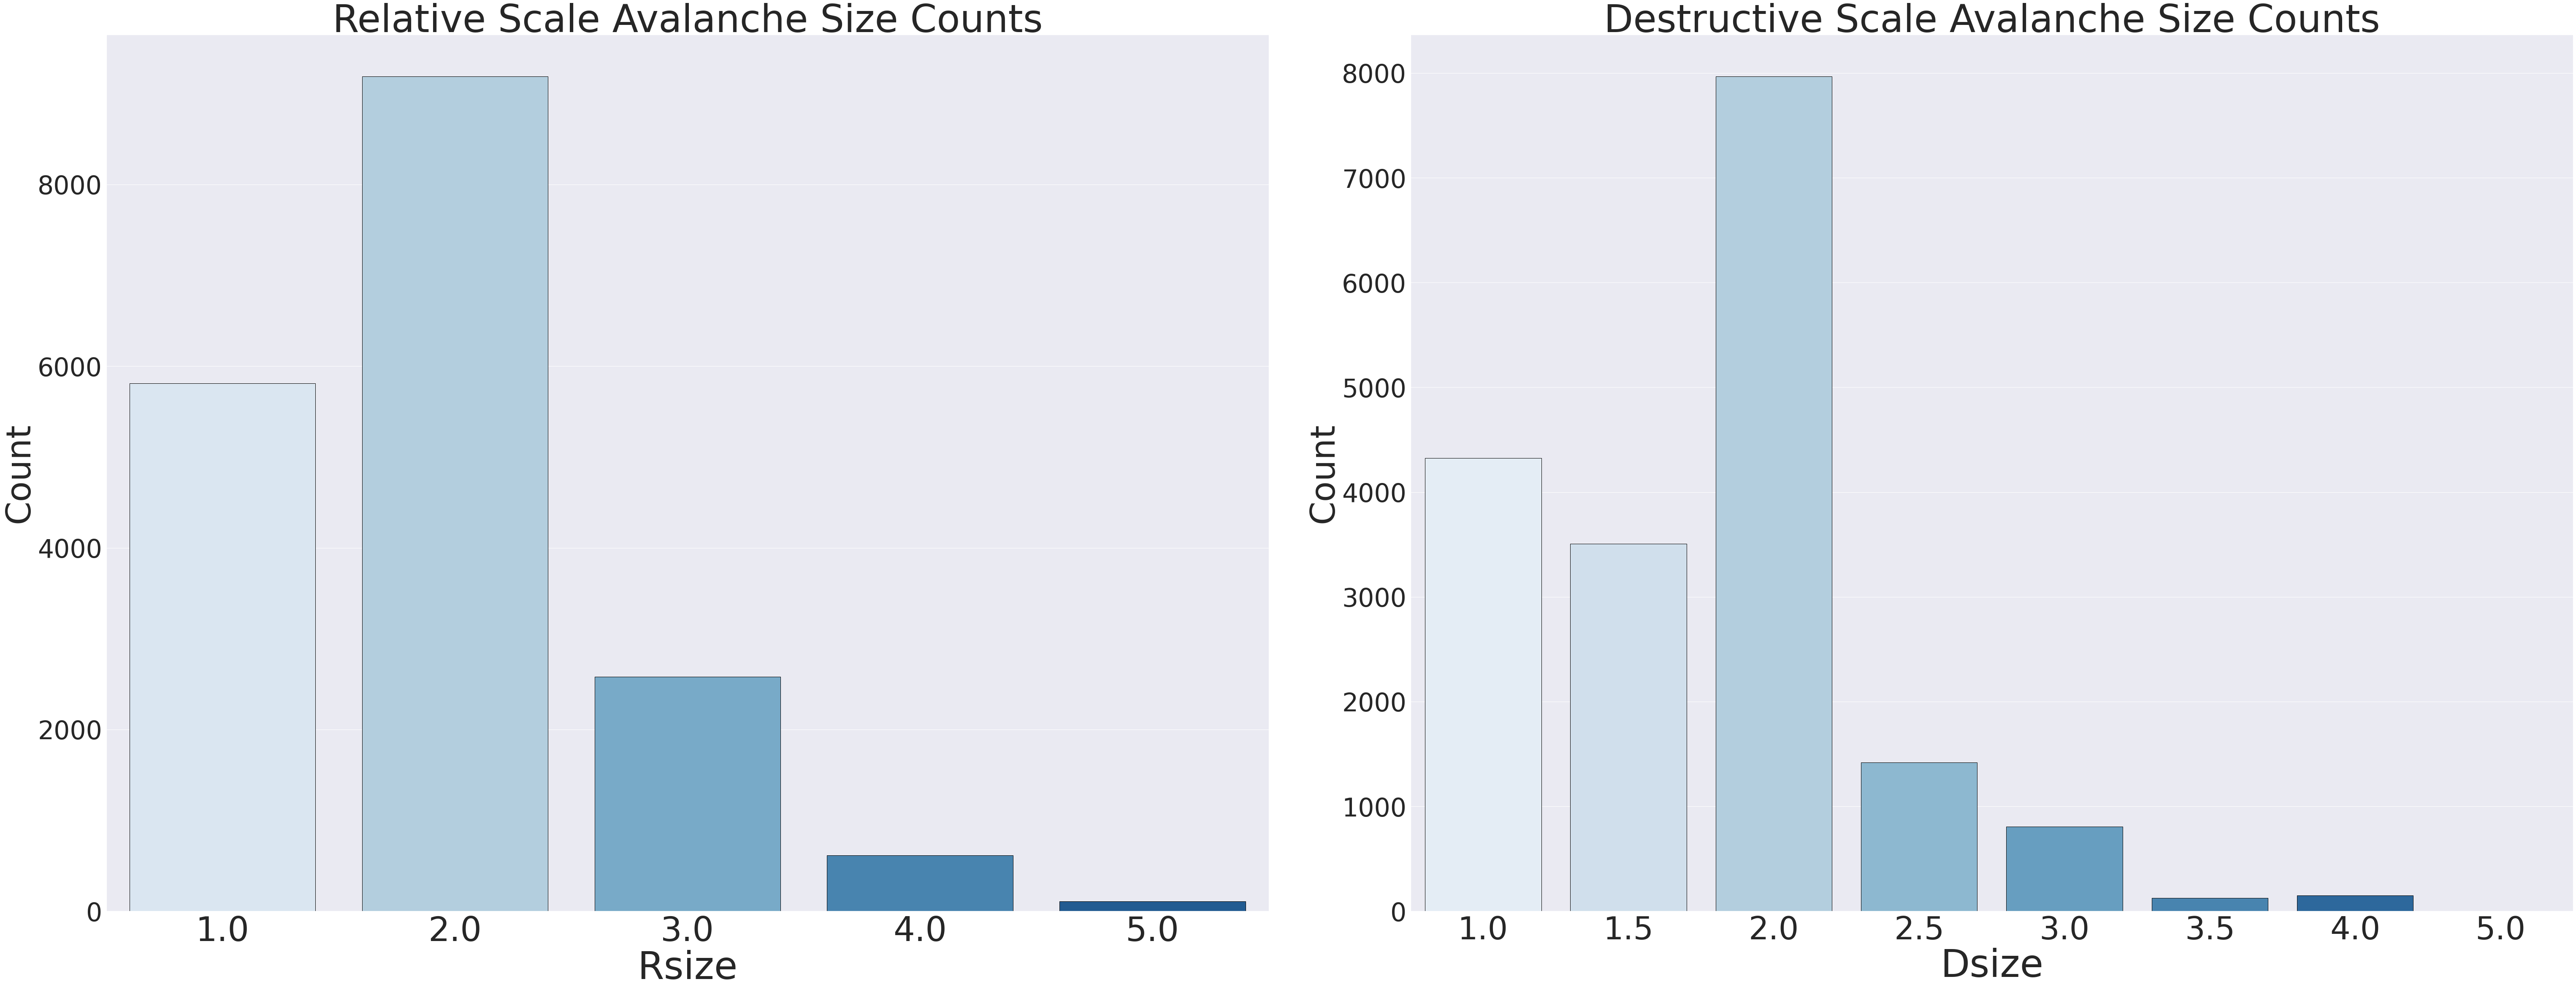

In [8]:
fig, ax = plt.subplots(1, 2)

fig.tight_layout(pad = 25, rect = (0, -0.5, 3, 2))
sns.countplot(x='Rsize', data = avalanches_df, palette = 'Blues', edgecolor = "Black", ax=ax[0])
sns.countplot(x='Dsize', data = avalanches_df, palette='Blues',edgecolor = "Black", ax = ax[1])
ax[0].set_title('Relative Scale Avalanche Size Counts', fontsize = 90)
ax[0].set_xlabel('Rsize', fontsize=90)
ax[0].set_ylabel('Count', fontsize=80)
ax[0].tick_params(axis='x', labelsize=80)
ax[0].tick_params(axis='y', labelsize=60)

ax[1].set_title('Destructive Scale Avalanche Size Counts', fontsize = 90)
ax[1].set_xlabel('Dsize', fontsize=90)
ax[1].set_ylabel('Count', fontsize=80)
ax[1].tick_params(axis='x', labelsize=75)
ax[1].tick_params(axis='y', labelsize=60)

fig.show()

### As we can see, the distribution of relative scale and destructive scale avalanches look approximately the same, a right skewed distribution with 2 being the most common size. 

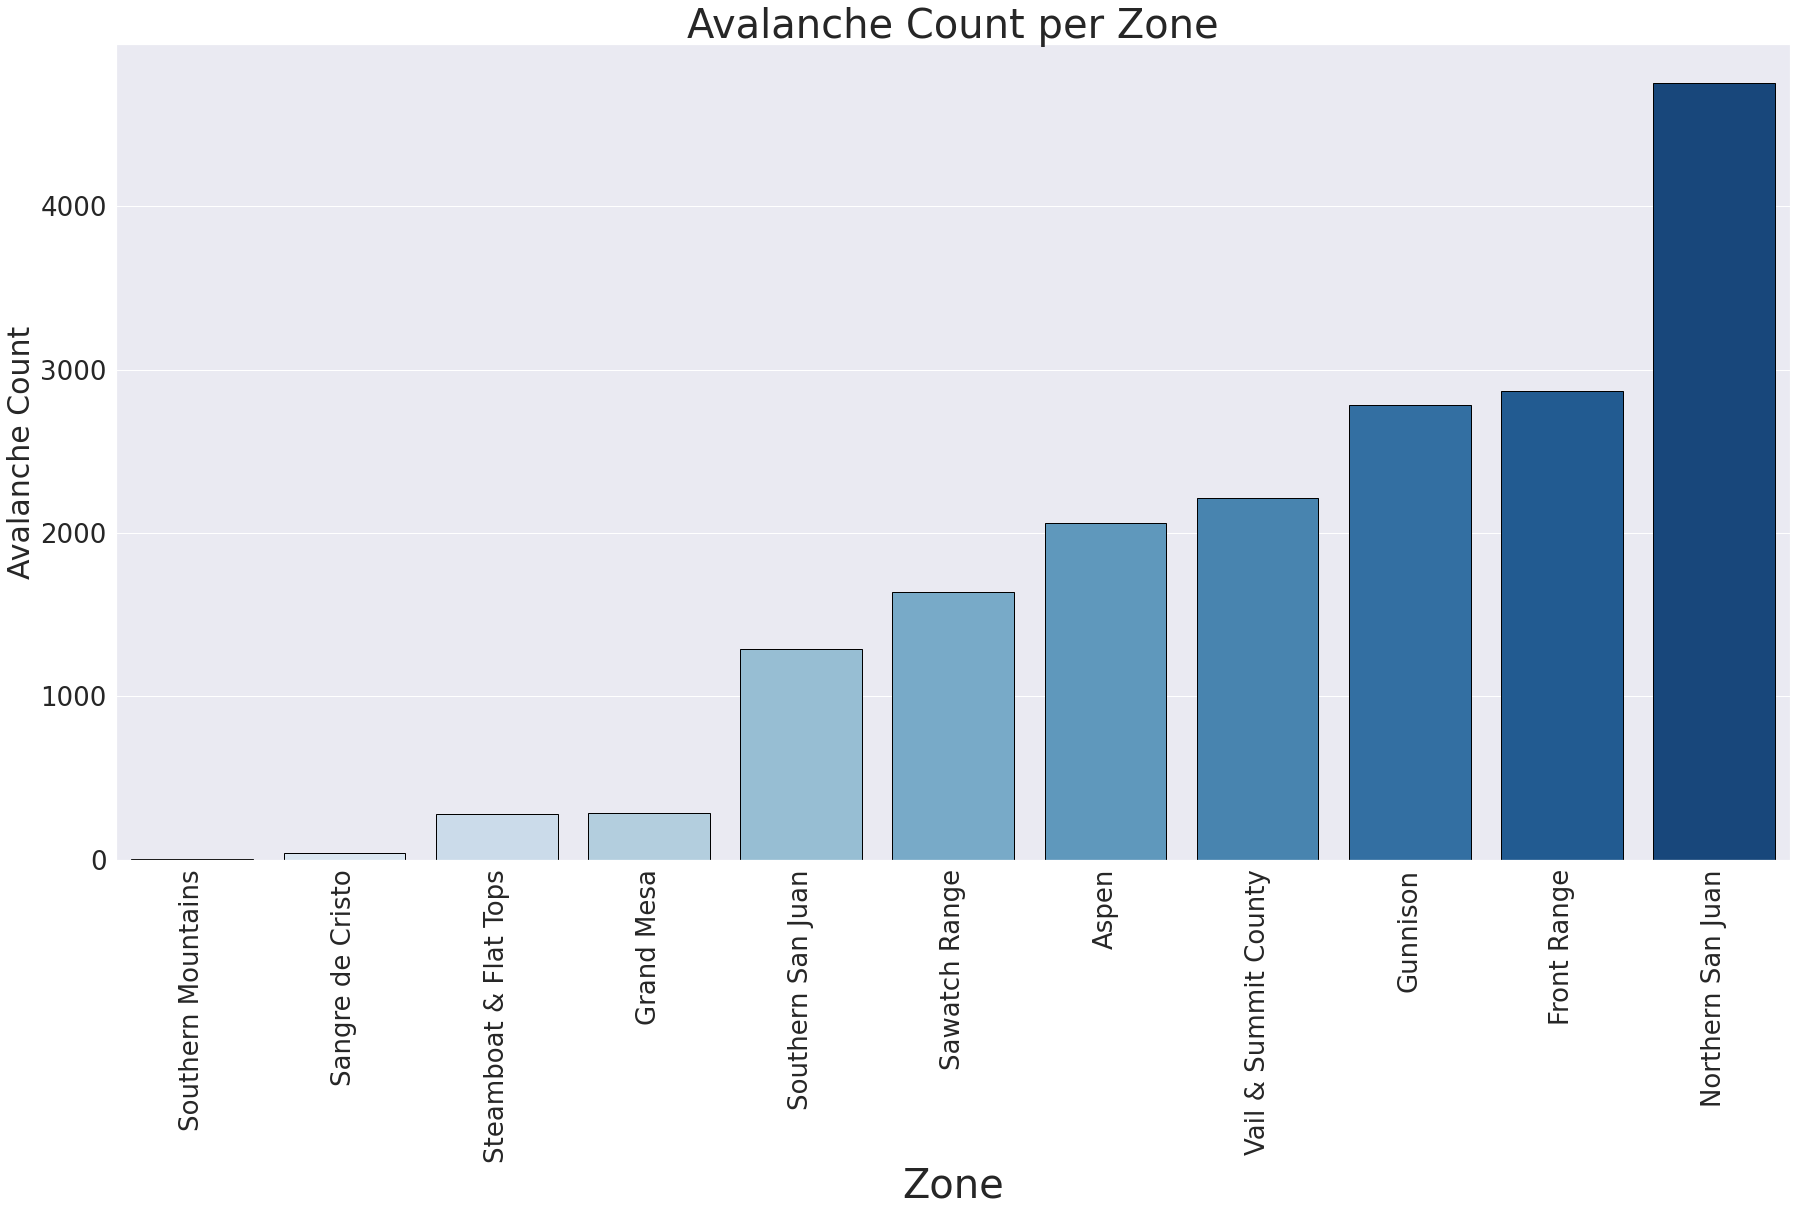

In [9]:
sns.set(rc={'figure.figsize':(30, 15)})
sns.countplot(x='Zone', data = avalanches_df, order = avalanches_df['Zone'].value_counts(ascending=True).index, edgecolor = "Black", palette='Blues')
plt.xticks(rotation = 90, fontsize = 26)
plt.yticks(fontsize=26)
plt.xlabel("Zone", fontsize=40)
plt.ylabel("Avalanche Count", fontsize=30)
plt.title("Avalanche Count per Zone", fontsize = 40)
plt.show()

### Here we have the counts of avalanches per zone, with the Southern Mountains having the fewest avalanches and the Northern San Juans having the greatest number of avalanches. 

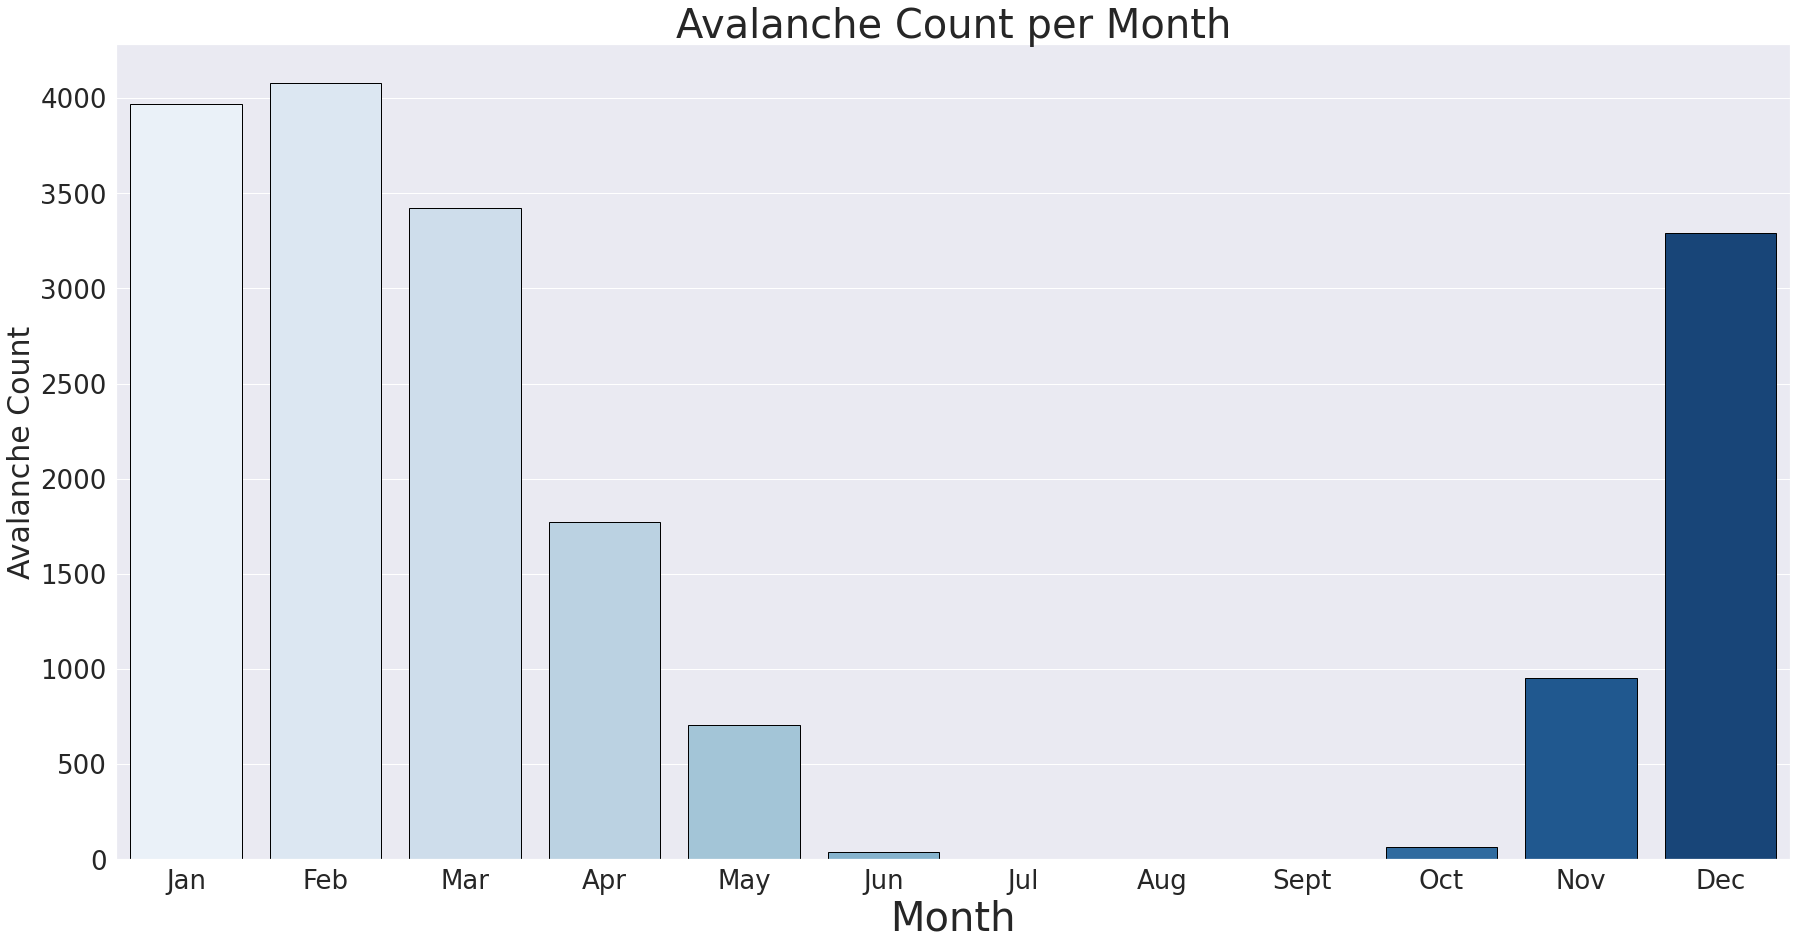

In [10]:
avalanches_df["Month"] = avalanches_df['Date'].apply(lambda x: x.month)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]

sns.set(rc={'figure.figsize':(30, 15)})
ax = sns.countplot(x='Month', data = avalanches_df, edgecolor = "Black", palette='Blues')
plt.xticks(fontsize = 26)
plt.yticks(fontsize=26)
plt.xlabel("Month", fontsize=40)
plt.ylabel("Avalanche Count", fontsize=30)
plt.title("Avalanche Count per Month", fontsize = 40)
ax.set_xticklabels(months)
plt.show()

### Unsurpisingly, the deep winter months have the highest avalanche counts and the summer months have the fewest. 